# **Importing Packages**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import distance_transform_edt
from uuid import uuid4
import torch.utils.checkpoint as checkpoint
import torch.backends.cudnn as cudnn
import gc

gc.collect()
torch.cuda.empty_cache()

cudnn.benchmark = True
cudnn.deterministic = False

import warnings
warnings.simplefilter("ignore")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

##**Dataset Class**

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, data_path, crop_size=(128, 160, 128), num_train=bool, num_val=bool, num_test=bool):
        self.data_path = data_path
        self.crop_size = crop_size
        all_patients = sorted([
            p for p in os.listdir(data_path)
            if os.path.isdir(os.path.join(data_path, p)) and ".ipynb_checkpoints" not in p
        ])

        if num_train:
            self.patients = all_patients[:]
        if num_val:
            self.patients = all_patients[:]
        if num_test:
            self.patients = all_patients[:]

    def load_nifti(self, filepath):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"File not found: {filepath}")
        img = nib.load(filepath)
        data = np.array(img.get_fdata(), dtype=np.float32)
        data = self.crop_center(data, self.crop_size)
        data = torch.tensor(data).unsqueeze(0).unsqueeze(0)
        return data.squeeze().numpy()

    def crop_center(self, volume, target_size):
        # Get the original dimensions
        D, H, W = volume.shape[-3:] if volume.ndim > 3 else volume.shape
        target_D, target_H, target_W = target_size

        # Calculate start and end indices for cropping
        # Ensure indices are within bounds and calculate the center
        start_d = max(0, (D - target_D) // 2)
        start_h = max(0, (H - target_H) // 2)
        start_w = max(0, (W - target_W) // 2)

        end_d = start_d + target_D
        end_h = start_h + target_H
        end_w = start_w + target_W

        # Perform the cropping
        # Use slicing adapted for potential extra dimensions (like channel if img)
        if volume.ndim > 3:
             # Assume shape is (C, D, H, W) or similar
            cropped_volume = volume[..., start_d:end_d, start_h:end_h, start_w:end_w]
        else:
            # Assume shape is (D, H, W)
             cropped_volume = volume[start_d:end_d, start_h:end_h, start_w:end_w]

        # Check if the cropped size matches the target size
        if cropped_volume.shape[-3:] != target_size:
             print(f"Warning: Cropped volume shape {cropped_volume.shape[-3:]} does not match target size {target_size}.")
             # You might want to add padding here if cropping resulted in a smaller size
             # For now, we'll just print a warning.
             pass
        return cropped_volume

    def __getitem__(self, idx):
        patient_folder = os.path.join(self.data_path, self.patients[idx])
        modalities = ['t1c', 't1n', 't2f', 't2w']
        image = np.stack([
            self.load_nifti(os.path.join(patient_folder, f"{self.patients[idx]}-{mod}.nii"))
            for mod in modalities
        ])
        mask = self.load_nifti(os.path.join(patient_folder, f"{self.patients[idx]}-seg.nii"))
        mask = mask.astype(np.int64)

        return image, mask

    def __len__(self):
        return len(self.patients)

# **3 Way Clustering integrated with Unet Model**

### **Model Architecture & Components**

In [ ]:
# Self-Attention Module
class LightweightSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.sigmoid(self.conv(x))
        return x * attention

# Model Components
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.InstanceNorm3d(out_channels, affine=False),
            nn.LeakyReLU(0.2),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.InstanceNorm3d(out_channels, affine=False),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        if self.training:
            return checkpoint.checkpoint(self.conv, x, use_reentrant=False)
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool3d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.attention = LightweightSelfAttention(out_channels)
        self.conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff = [x2.size()[i] - x1.size()[i] for i in range(2, 5)]
        x1 = F.pad(x1, [
            diff[2]//2, diff[2]-diff[2]//2,
            diff[1]//2, diff[1]-diff[1]//2,
            diff[0]//2, diff[0]-diff[0]//2
        ])
        x2 = self.attention(x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

## **3WC Module**

In [ ]:
class ThreeWayClustering(nn.Module):
    def __init__(self, feature_dim, num_clusters=3, boundary_threshold=0.65):
        super().__init__()
        self.conv = nn.Conv3d(feature_dim, num_clusters, kernel_size=1)
        self.boundary_threshold = boundary_threshold

    def forward(self, x):
        cluster_logits = self.conv(x)
        cluster_probs = F.softmax(cluster_logits, dim=1)
        max_probs, cluster_assignments = torch.max(cluster_probs, dim=1, keepdim=True)
        boundary_mask = (max_probs < self.boundary_threshold).float()
        core = (cluster_probs[:, 0:1] > 0.8).float()
        fringe = ((cluster_probs[:, 0:1] <= 0.8) & (cluster_probs[:, 0:1] > 0.4)).float()
        boundary = boundary_mask
        return cluster_probs, core, fringe, boundary, cluster_assignments

## **Main Model**

In [ ]:
# Main Model
class _3WC_UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.inc = DoubleConv(in_channels, 16)
        self.down1 = DownBlock(16, 32)
        self.down2 = DownBlock(32, 64)
        self.down3 = DownBlock(64, 128)
        self.cluster1 = ThreeWayClustering(32)
        self.cluster2 = ThreeWayClustering(64)
        self.cluster3 = ThreeWayClustering(128)
        self.up1 = UpBlock(128, 64)
        self.up2 = UpBlock(64, 32)
        self.up3 = UpBlock(32, 16)
        self.outc = nn.Conv3d(16, out_channels, kernel_size=1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        cp1, core1, fringe1, boundary1, ca1 = self.cluster1(x2)
        cp2, core2, fringe2, boundary2, ca2 = self.cluster2(x3)
        cp3, core3, fringe3, boundary3, ca3 = self.cluster3(x4)
        x = self.up1(x4, x3 * F.interpolate(boundary3, size=x3.shape[2:], mode='trilinear'))
        x = self.up2(x, x2 * F.interpolate(boundary2, size=x2.shape[2:], mode='trilinear'))
        x = self.up3(x, x1 * F.interpolate(boundary1, size=x1.shape[2:], mode='trilinear'))
        return {
            'segmentation': self.outc(x),
            'cluster_probs': [cp1, cp2, cp3],
            'core_masks': [core1, core2, core3],
            'fringe_masks': [fringe1, fringe2, fringe3],
            'boundary_masks': [boundary1, boundary2, boundary3],
            'cluster_assignments': [ca1, ca2, ca3]
        }


## **Loss Functions**

In [ ]:

def dice_score(pred, target, smooth=1e-5):
    pred = F.softmax(pred, dim=1)
    target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 4, 1, 2, 3).float()
    intersection = (pred * target_one_hot).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target_one_hot.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, smooth=1e-5):
    pred = torch.argmax(pred, dim=1)
    target = target.long()
    intersection = (pred == target).float().sum((1, 2, 3))
    union = (pred >= 0).float().sum((1, 2, 3)) + (target >= 0).float().sum((1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

def hausdorff_95(pred, target, voxel_spacing=(1, 1, 1)):
    pred = torch.argmax(pred, dim=1).cpu().numpy()
    target = target.cpu().numpy()
    hd_scores = []
    for b in range(pred.shape[0]):
        for c in range(1, 4):  # Skip background
            pred_mask = (pred[b] == c).astype(np.uint8)
            target_mask = (target[b] == c).astype(np.uint8)
            if pred_mask.sum() == 0 or target_mask.sum() == 0:
                continue
            pred_dist = distance_transform_edt(1 - pred_mask)
            target_dist = distance_transform_edt(1 - target_mask)
            pred_to_target = pred_dist[target_mask > 0]
            target_to_pred = target_dist[pred_mask > 0]
            distances = np.concatenate([pred_to_target, target_to_pred])
            if len(distances) > 0:
                hd_95 = np.percentile(distances, 95) * voxel_spacing[0]
                hd_scores.append(hd_95)
    return np.mean(hd_scores) if hd_scores else 0.0

## **Training Function**

In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, optimizer, num_epochs=3, accum_steps=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    scaler = torch.amp.GradScaler('cuda')

    train_losses = []
    val_losses = []
    dice_scores = []
    iou_scores = []
    hd95_scores = []
    boundary_ratios = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_dice = 0
        epoch_iou = 0
        epoch_hd95 = 0
        cluster_stats = []
        volume_count = 0 # Changed from patch_count to volume_count

        # Initialize tqdm progress bar for training batches
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        # Iterate over whole volumes instead of patches
        for images, masks in progress_bar:
            try:
                optimizer.zero_grad(set_to_none=True)

                # Assuming batch size is 1 for whole volumes, squeeze the batch dimension
                # Ensure tensors are in the correct shape: [N, C, D, H, W] for images, [N, D, H, W] for masks
                if images.ndim == 4: # Assuming input shape is [C, D, H, W]
                    images = images.unsqueeze(0) # Add batch dimension
                if masks.ndim == 3: # Assuming mask shape is [D, H, W]
                    masks = masks.unsqueeze(0) # Add batch dimension
                elif masks.ndim == 5: # Assuming mask shape is [N, 1, D, H, W]
                    masks = masks.squeeze(1) # Remove channel dimension

                images = images.to(device, non_blocking=True).float()
                masks = masks.to(device, non_blocking=True).long().clamp(0, 3)


                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    seg = outputs['segmentation']

                    # Ensure target mask has correct shape for cross_entropy
                    # Cross entropy expects (N, D, H, W) for target with class indices
                    seg_loss = F.cross_entropy(seg, masks)

                    # Dice score function needs target as (N, D, H, W) or (N, 1, D, H, W)
                    dice = dice_score(seg, masks)

                    # Boundary loss calculation
                    boundary_mask = outputs['boundary_masks'][-1]
                    # Interpolate boundary mask to segmentation output size
                    boundary_mask = F.interpolate(boundary_mask, size=seg.shape[2:], mode='trilinear', align_corners=False)
                    # Create tumor mask from ground truth (excluding background class 0)
                    tumor_mask = (masks > 0).float()
                    # Apply boundary and tumor masks to cross-entropy loss for boundary loss
                    boundary_loss = (F.cross_entropy(seg, masks, reduction='none') * boundary_mask.squeeze(1) * tumor_mask).sum() / (boundary_mask.sum() + 1e-5)

                    total_loss = (seg_loss + dice + 0.2 * boundary_loss) / accum_steps # Apply accumulation steps

                # Accumulate gradients
                scaler.scale(total_loss).backward()

                epoch_train_loss += total_loss.item() * accum_steps # Scale back loss for reporting
                epoch_dice += dice.item()
                epoch_iou += iou_score(seg, masks) # IoU score calculation adjusted for whole volumes
                epoch_hd95 += hausdorff_95(seg, masks) # HD95 calculation adjusted
                cluster_stats.append(boundary_mask.mean().item())
                volume_count += 1 # Increment volume count

                # Perform optimizer step and clear gradients if accumulation steps are met
                if (volume_count % accum_steps) == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)


                del images, masks, outputs, seg, boundary_mask, total_loss
                torch.cuda.empty_cache()

                # Update progress bar description with memory usage
                progress_bar.set_postfix({
                    'Allocated': f"{torch.cuda.memory_allocated()/1e9:.2f} GB",
                    'Reserved': f"{torch.cuda.memory_reserved()/1e9:.2f} GB"
                })

            except RuntimeError as e:
                print(f"Training error: {e}")
                torch.cuda.empty_cache()
                continue
            except Exception as e:
                print(f"An unexpected error occurred during training: {e}")
                torch.cuda.empty_cache()
                continue


        progress_bar.close()

        # Perform optimizer step for any remaining accumulated gradients
        if (volume_count % accum_steps) != 0:
             scaler.step(optimizer)
             scaler.update()
             optimizer.zero_grad(set_to_none=True)


        # Validation
        model.eval()
        epoch_val_loss = 0
        epoch_val_dice = 0
        epoch_val_iou = 0
        epoch_val_hd95 = 0
        val_volume_count = 0 # Changed from val_patch_count to val_volume_count

        val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=True)

        with torch.no_grad():
            # Iterate over whole volumes for validation
            for images, masks in val_progress_bar:

                # Assuming batch size is 1 for whole volumes, squeeze the batch dimension
                if images.ndim == 4: # Assuming input shape is [C, D, H, W]
                    images = images.unsqueeze(0) # Add batch dimension
                if masks.ndim == 3: # Assuming mask shape is [D, H, W]
                    masks = masks.unsqueeze(0) # Add batch dimension
                elif masks.ndim == 5: # Assuming mask shape is [N, 1, D, H, W]
                    masks = masks.squeeze(1) # Remove channel dimension

                images = images.to(device, non_blocking=True).float()
                masks = masks.to(device, non_blocking=True).long().clamp(0, 3)

                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    seg = outputs['segmentation']

                    # Calculate validation metrics
                    val_loss = F.cross_entropy(seg, masks)
                    val_dice = dice_score(seg, masks)
                    val_iou = iou_score(seg, masks)
                    val_hd95 = hausdorff_95(seg, masks)

                epoch_val_loss += val_loss.item()
                epoch_val_dice += val_dice.item()
                epoch_val_iou += val_iou
                epoch_val_hd95 += val_hd95
                val_volume_count += 1 # Increment validation volume count

                del images, masks, outputs, seg
                torch.cuda.empty_cache()

                # Update validation progress bar
                val_progress_bar.set_postfix({
                    'Allocated': f"{torch.cuda.memory_allocated()/1e9:.2f} GB",
                    'Reserved': f"{torch.cuda.memory_reserved()/1e9:.2f} GB"
                })

        val_progress_bar.close()


        # Record metrics - calculate averages over volumes
        avg_train_loss = epoch_train_loss / volume_count if volume_count > 0 else 0
        avg_val_loss = epoch_val_loss / val_volume_count if val_volume_count > 0 else 0
        avg_dice = epoch_dice / volume_count if volume_count > 0 else 0
        avg_val_dice = epoch_val_dice / val_volume_count if val_volume_count > 0 else 0
        avg_iou = epoch_iou / volume_count if volume_count > 0 else 0
        avg_val_iou = epoch_val_iou / val_volume_count if val_volume_count > 0 else 0
        avg_hd95 = epoch_hd95 / volume_count if volume_count > 0 else 0
        avg_val_hd95 = epoch_val_hd95 / val_volume_count if val_volume_count > 0 else 0
        avg_boundary_ratio = np.mean(cluster_stats) if cluster_stats else 0

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        # Ensure metrics are stored as lists of floats/tuples
        dice_scores.append((avg_dice, avg_val_dice))
        iou_scores.append((avg_iou, avg_val_iou))
        hd95_scores.append((avg_hd95, avg_val_hd95))
        boundary_ratios.append(avg_boundary_ratio)


        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Train Dice_Score: {avg_dice:.4f}, Val Dice_Score: {avg_val_dice:.4f}, '
              f'Train IoU: {avg_iou:.4f}, Val IoU: {avg_val_iou:.4f}, '
              f'Train HD95: {avg_hd95:.4f}, Val HD95: {avg_val_hd95:.4f}, '
              f'Boundary Ratio: {avg_boundary_ratio:.4f}')

    return train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios

## **Saving Model**

In [ ]:
import torch
import os
import json
from datetime import datetime

def save_model_with_features(model, optimizer, train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios, save_dir="/kaggle/working"):

    """
    Save the model with its features (weights, architecture, metrics, and hyperparameters).
    """

    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Generate a unique timestamp for the save file
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"OurModel_{timestamp}.pth"
    config_filename = f"OurModel_config_{timestamp}.json"
    metrics_filename = f"OurModel_metrics_{timestamp}.json"

    # Save model state dictionary
    model_state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'hyperparameters': {
            'crop_size': (128* 160* 128),  # Default from your setup
            'num_epochs': 20,                # Update based on your training
            'accum_steps': 2,               # Default from your setup
            'lr': 1e-4,                     # Default learning rate
            'weight_decay': 1e-5            # Default weight decay
        }
    }
    torch.save(model_state, os.path.join(save_dir, model_filename))

    # Save model architecture (as a string representation for reconstruction)
    model_config = {
        'architecture': str(model),
        'class_name': model.__class__.__name__
    }
    with open(os.path.join(save_dir, config_filename), 'w') as f:
        json.dump(model_config, f, indent=4)

    # Save training metrics
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'dice_scores': [[float(t), float(v)] for t, v in dice_scores],
        'iou_scores': [[float(t), float(v)] for t, v in iou_scores],
        'hd95_scores': [[float(t), float(v)] for t, v in hd95_scores],
        'boundary_ratios': [float(r) for r in boundary_ratios]
    }
    with open(os.path.join(save_dir, metrics_filename), 'w') as f:
        json.dump(metrics, f, indent=4)

    print(f"Model saved to {os.path.join(save_dir, model_filename)}")
    print(f"Configuration saved to {os.path.join(save_dir, config_filename)}")
    print(f"Metrics saved to {os.path.join(save_dir, metrics_filename)}")


# **PLOT**

In [ ]:
def plot_results(model, val_loader, train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    # Plot 1: Metrics (Loss, Dice, IoU, HD95, Boundary Ratio)
    plt.figure(figsize=(20, 10))

    # Subplot 1: Training and Validation Loss
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Dice Loss
    train_dice, val_dice = zip(*dice_scores)
    plt.subplot(2, 3, 2)
    plt.plot(train_dice, label='Train Dice')
    plt.plot(val_dice, label='Val Dice')
    plt.title('Dice Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Loss')
    plt.legend()
    plt.grid(True)

    # Subplot 3: IoU Scores
    train_iou, val_iou = zip(*iou_scores)
    plt.subplot(2, 3, 3)
    plt.plot(train_iou, label='Train IoU')
    plt.plot(val_iou, label='Val IoU')
    plt.title('IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    # Subplot 4: HD95 Scores
    train_hd95, val_hd95 = zip(*hd95_scores)
    plt.subplot(2, 3, 4)
    plt.plot(train_hd95, label='Train HD95')
    plt.plot(val_hd95, label='Val HD95')
    plt.title('Hausdorff Distance (95th Percentile)')
    plt.xlabel('Epoch')
    plt.ylabel('HD95 (mm)')
    plt.legend()
    plt.grid(True)

    # Subplot 5: Boundary Ratio
    plt.subplot(2, 3, 5)
    plt.plot(boundary_ratios, label='Boundary Ratio')
    plt.title('Boundary Region Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig('/kaggle/working/results.png')


## **Train Execution**

Epoch 1/20: 100%|██████████| 100/100 [06:21<00:00,  3.82s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 1/20: Train Loss: 2.0488, Val Loss: 1.9209, Train Dice_Score: 0.0892, Val Dice_Score: 0.0851, Train IoU: 0.0447, Val IoU: 0.0416, Train HD95: 5.4551, Val HD95: 4.5357, Boundary Ratio: 0.3915


Epoch 2/20: 100%|██████████| 100/100 [06:37<00:00,  3.98s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 2/20: Train Loss: 2.0033, Val Loss: 1.9081, Train Dice_Score: 0.0855, Val Dice_Score: 0.0823, Train IoU: 0.0478, Val IoU: 0.0535, Train HD95: 5.4931, Val HD95: 4.5935, Boundary Ratio: 0.3936


Epoch 3/20: 100%|██████████| 100/100 [06:48<00:00,  4.08s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 3/20: Train Loss: 1.8913, Val Loss: 1.7415, Train Dice_Score: 0.0900, Val Dice_Score: 0.0912, Train IoU: 0.0574, Val IoU: 0.0448, Train HD95: 5.4589, Val HD95: 4.4171, Boundary Ratio: 0.3985


Epoch 4/20: 100%|██████████| 100/100 [07:02<00:00,  4.23s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 4/20: Train Loss: 1.7925, Val Loss: 1.6248, Train Dice_Score: 0.0958, Val Dice_Score: 0.0986, Train IoU: 0.0471, Val IoU: 0.0482, Train HD95: 5.3131, Val HD95: 4.4563, Boundary Ratio: 0.3998


Epoch 5/20: 100%|██████████| 100/100 [06:44<00:00,  4.05s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 5/20: Train Loss: 1.7309, Val Loss: 1.6620, Train Dice_Score: 0.1007, Val Dice_Score: 0.0980, Train IoU: 0.0543, Val IoU: 0.0575, Train HD95: 5.3304, Val HD95: 4.4491, Boundary Ratio: 0.4253


Epoch 6/20: 100%|██████████| 100/100 [06:59<00:00,  4.20s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 6/20: Train Loss: 1.7292, Val Loss: 1.6185, Train Dice_Score: 0.1020, Val Dice_Score: 0.1005, Train IoU: 0.0680, Val IoU: 0.0706, Train HD95: 5.3706, Val HD95: 4.4644, Boundary Ratio: 0.3740


Epoch 7/20: 100%|██████████| 100/100 [06:43<00:00,  4.03s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 7/20: Train Loss: 1.5150, Val Loss: 1.2873, Train Dice_Score: 0.1158, Val Dice_Score: 0.1208, Train IoU: 0.2563, Val IoU: 0.4419, Train HD95: 5.1964, Val HD95: 4.1456, Boundary Ratio: 0.3821


Epoch 8/20: 100%|██████████| 100/100 [07:04<00:00,  4.24s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 8/20: Train Loss: 1.4388, Val Loss: 1.3463, Train Dice_Score: 0.1210, Val Dice_Score: 0.1171, Train IoU: 0.3477, Val IoU: 0.2197, Train HD95: 5.1352, Val HD95: 4.3952, Boundary Ratio: 0.3508


Epoch 9/20: 100%|██████████| 100/100 [07:11<00:00,  4.31s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 9/20: Train Loss: 1.5361, Val Loss: 1.4812, Train Dice_Score: 0.1146, Val Dice_Score: 0.1086, Train IoU: 0.1660, Val IoU: 0.1293, Train HD95: 5.3149, Val HD95: 4.5322, Boundary Ratio: 0.2456


Epoch 10/20: 100%|██████████| 100/100 [07:04<00:00,  4.25s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 10/20: Train Loss: 1.5710, Val Loss: 1.4469, Train Dice_Score: 0.1120, Val Dice_Score: 0.1112, Train IoU: 0.1335, Val IoU: 0.1237, Train HD95: 5.5001, Val HD95: 4.5946, Boundary Ratio: 0.2115


Epoch 11/20: 100%|██████████| 100/100 [06:33<00:00,  3.93s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 11/20: Train Loss: 1.5615, Val Loss: 1.4628, Train Dice_Score: 0.1127, Val Dice_Score: 0.1096, Train IoU: 0.1250, Val IoU: 0.1150, Train HD95: 5.6020, Val HD95: 4.6967, Boundary Ratio: 0.2080


Epoch 12/20: 100%|██████████| 100/100 [07:00<00:00,  4.20s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 12/20: Train Loss: 1.6019, Val Loss: 1.4961, Train Dice_Score: 0.1099, Val Dice_Score: 0.1071, Train IoU: 0.1080, Val IoU: 0.0951, Train HD95: 5.6164, Val HD95: 4.6438, Boundary Ratio: 0.2182


Epoch 13/20: 100%|██████████| 100/100 [06:33<00:00,  3.94s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 13/20: Train Loss: 1.6054, Val Loss: 1.4758, Train Dice_Score: 0.1114, Val Dice_Score: 0.1115, Train IoU: 0.1353, Val IoU: 0.1474, Train HD95: 5.6416, Val HD95: 4.6811, Boundary Ratio: 0.2059


Epoch 14/20: 100%|██████████| 100/100 [06:59<00:00,  4.20s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 14/20: Train Loss: 1.5588, Val Loss: 1.4479, Train Dice_Score: 0.1139, Val Dice_Score: 0.1114, Train IoU: 0.1270, Val IoU: 0.1183, Train HD95: 5.6199, Val HD95: 4.6661, Boundary Ratio: 0.1527


Epoch 15/20: 100%|██████████| 100/100 [08:14<00:00,  4.94s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 15/20: Train Loss: 1.5945, Val Loss: 1.4997, Train Dice_Score: 0.1103, Val Dice_Score: 0.1069, Train IoU: 0.1171, Val IoU: 0.1052, Train HD95: 5.6225, Val HD95: 4.6440, Boundary Ratio: 0.1668


Epoch 16/20: 100%|██████████| 100/100 [07:16<00:00,  4.37s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 16/20: Train Loss: 1.5477, Val Loss: 1.4551, Train Dice_Score: 0.1133, Val Dice_Score: 0.1098, Train IoU: 0.1038, Val IoU: 0.0886, Train HD95: 5.5164, Val HD95: 4.5046, Boundary Ratio: 0.1690


Epoch 17/20: 100%|██████████| 100/100 [07:14<00:00,  4.35s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 17/20: Train Loss: 1.5825, Val Loss: 1.5156, Train Dice_Score: 0.1121, Val Dice_Score: 0.1067, Train IoU: 0.0828, Val IoU: 0.0779, Train HD95: 5.5183, Val HD95: 4.5848, Boundary Ratio: 0.2031


Epoch 18/20: 100%|██████████| 100/100 [06:55<00:00,  4.15s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 18/20: Train Loss: 1.6072, Val Loss: 1.4950, Train Dice_Score: 0.1081, Val Dice_Score: 0.1056, Train IoU: 0.0781, Val IoU: 0.0801, Train HD95: 5.5180, Val HD95: 4.5518, Boundary Ratio: 0.2106


Epoch 19/20: 100%|██████████| 100/100 [07:10<00:00,  4.31s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 19/20: Train Loss: 1.5974, Val Loss: 1.5063, Train Dice_Score: 0.1096, Val Dice_Score: 0.1079, Train IoU: 0.0975, Val IoU: 0.1193, Train HD95: 5.5675, Val HD95: 4.6793, Boundary Ratio: 0.4202


Epoch 20/20: 100%|██████████| 100/100 [07:11<00:00,  4.31s/it, Allocated=0.00 GB, Reserved=0.01 GB]


Epoch 20/20: Train Loss: 1.6184, Val Loss: 1.4993, Train Dice_Score: 0.1102, Val Dice_Score: 0.1095, Train IoU: 0.1353, Val IoU: 0.1605, Train HD95: 5.6800, Val HD95: 4.7059, Boundary Ratio: 0.4653
Model saved to model_checkpoints/23June_model_20250623_113148.pth
Configuration saved to model_checkpoints/23June_config_20250623_113148.json
Metrics saved to model_checkpoints/23June_metrics_20250623_113148.json


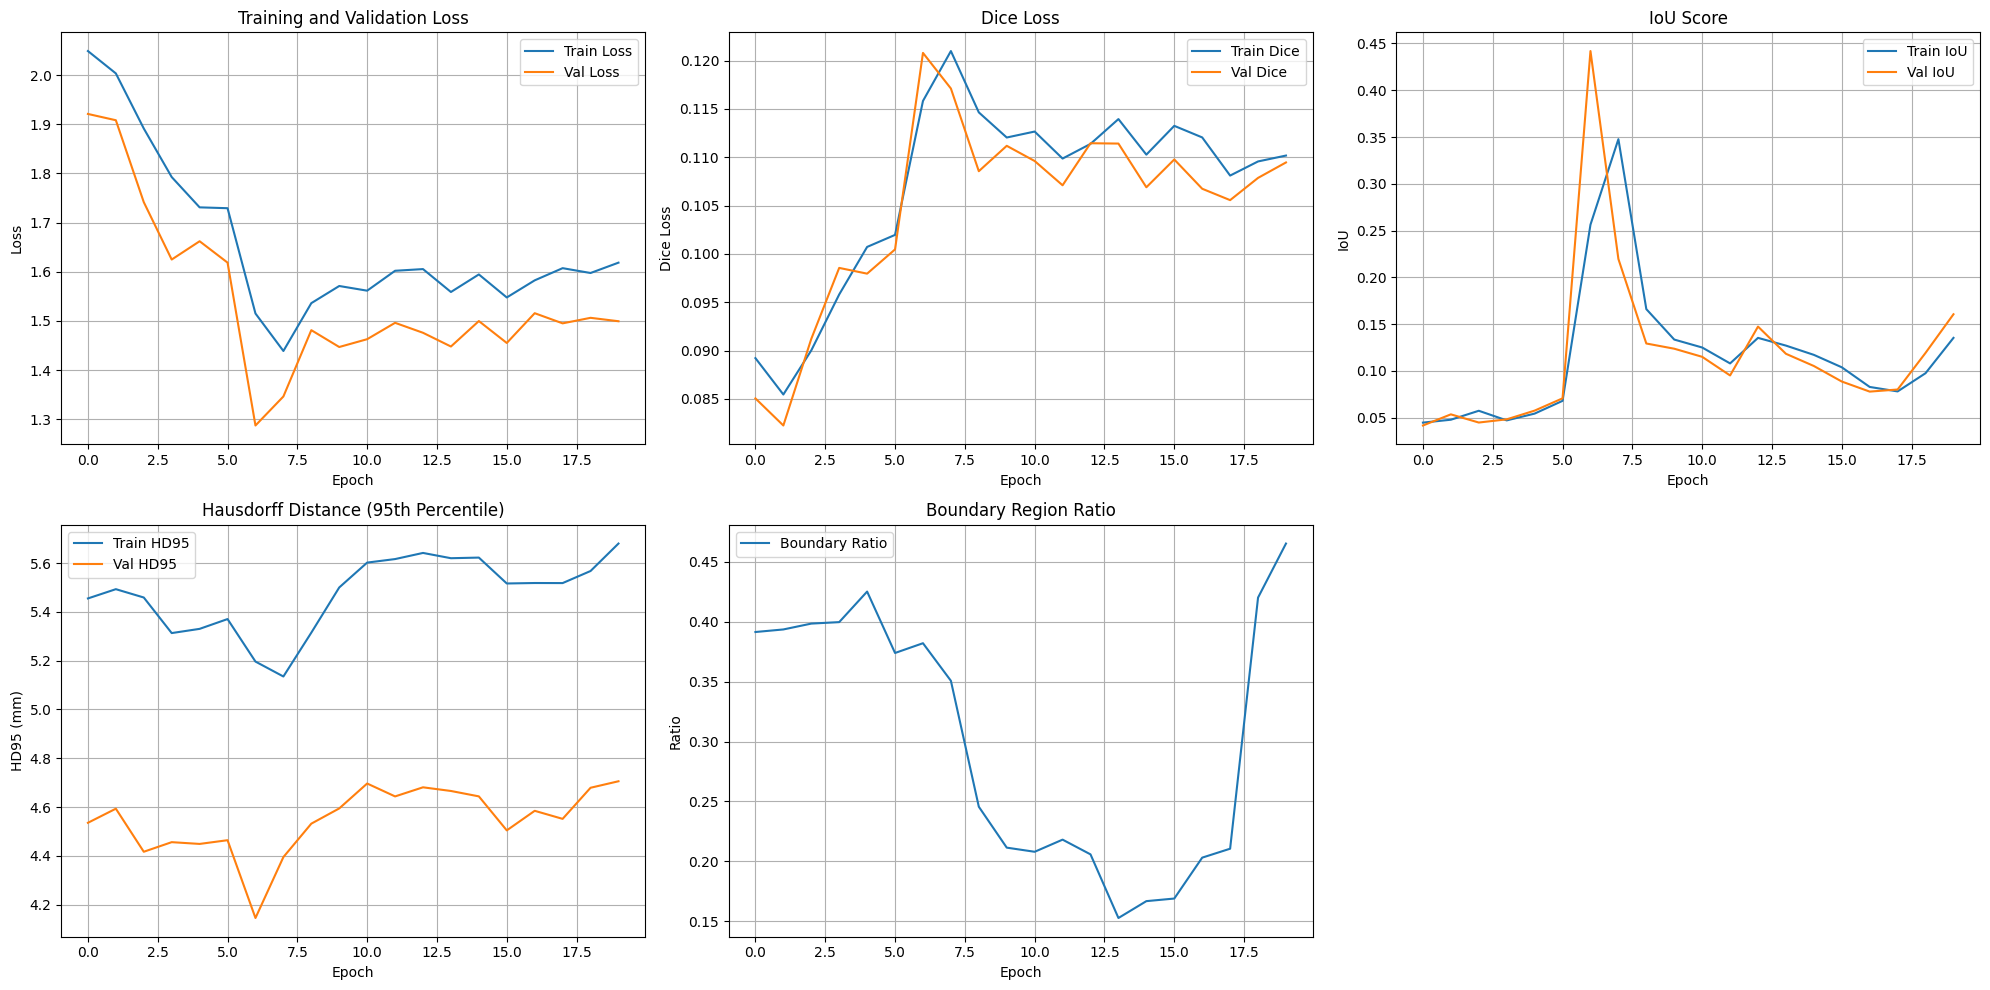

In [ ]:
# Training Execution
if __name__ == "__main__":
    train_data_path = "/content/drive/MyDrive/BraTS_Segmentation_Project/data/train"
    val_data_path = "/content/drive/MyDrive/BraTS_Segmentation_Project/data/val"
    train_dataset = BraTSDataset(train_data_path, crop_size=(128, 160, 128), num_train=True, num_val=False, num_test=False)
    val_dataset = BraTSDataset(val_data_path, crop_size=(128, 160, 128), num_train=False, num_val=True, num_test=False)
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False, num_workers=2, pin_memory=True)
    model = _3WC_UNet()
    model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios = train_model(
        model, train_loader, val_loader, optimizer, num_epochs=20, accum_steps=2
    )


save_model_with_features(model, optimizer, train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios)
plot_results(model, val_loader, train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios)

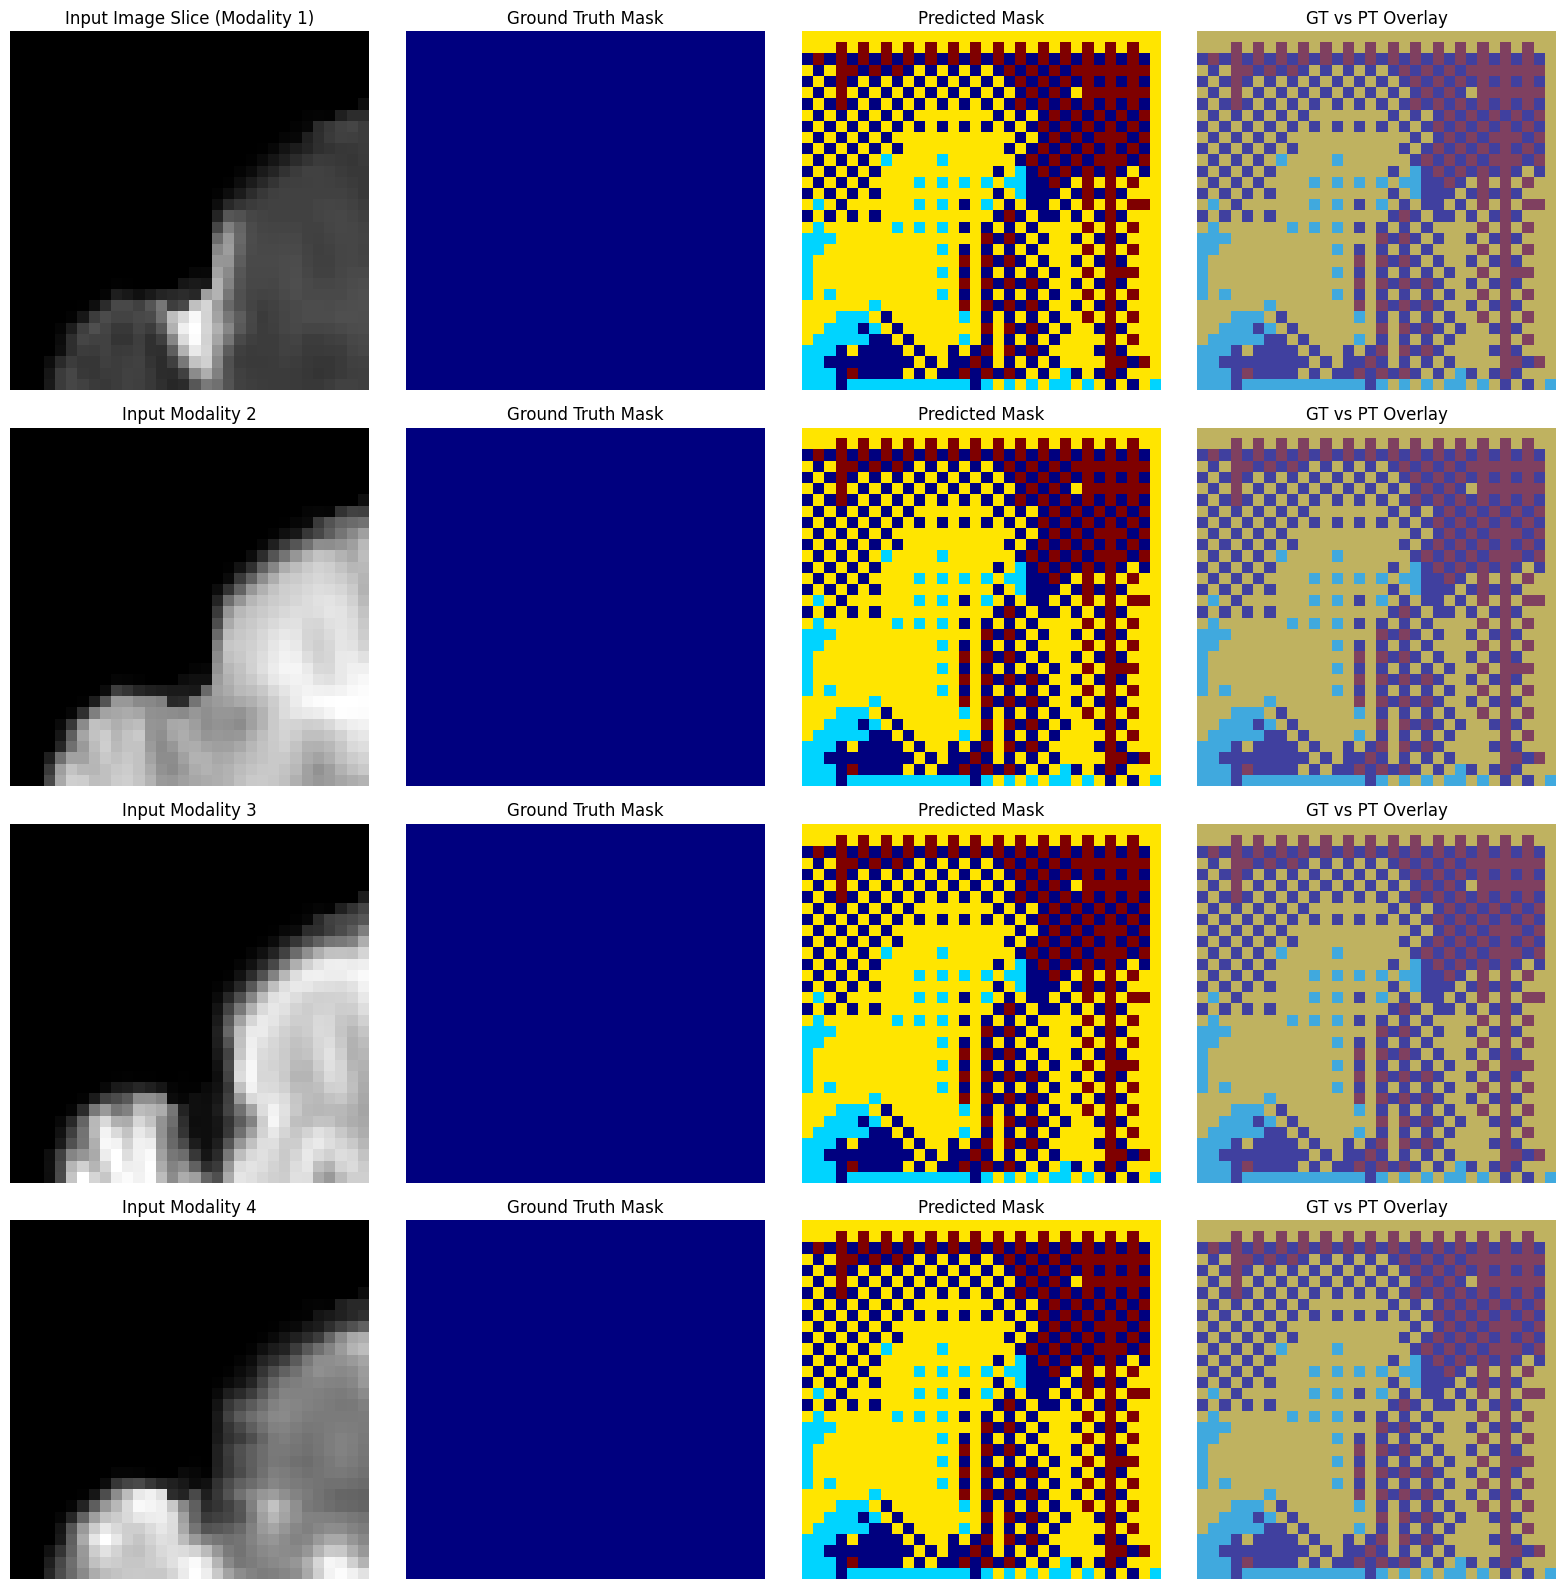

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_results(model, val_loader, train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    # 4x4 Subplot for Visualization
    plt.figure(figsize=(16, 16))

    with torch.no_grad():
        # Get the underlying dataset from the DataLoader
        val_dataset = val_loader.dataset
        # Randomly select an index from the validation dataset
        random_idx = random.randint(0, len(val_dataset) - 1)
        # Fetch the random sample
        image_patches, mask_patches = val_dataset[random_idx]

        # Convert the first patch from NumPy to PyTorch tensor
        image_patch = torch.from_numpy(image_patches[0]).float()
        mask_patch = torch.from_numpy(mask_patches[0]).long()

        if image_patch.ndim == 4:  # Shape: [C, D, H, W]
            image_patch = image_patch.unsqueeze(0)  # Add batch dimension: [1, C, D, H, W]
        if mask_patch.ndim == 5:  # Shape: [1, 1, D, H, W]
            mask_patch = mask_patch.squeeze(0)  # Remove channel dimension if present: [D, H, W]
        elif mask_patch.ndim == 4:  # Shape: [1, D, H, W]
            mask_patch = mask_patch.squeeze(0)  # Remove batch dimension: [D, H, W]

        # Move to GPU for inference, then back to CPU for visualization
        image_patch = image_patch.to(device, non_blocking=True)
        mask_patch = mask_patch.to(device, non_blocking=True).clamp(0, 3)

        outputs = model(image_patch)
        pred_mask = torch.argmax(outputs['segmentation'], dim=1)[0]

        # Move tensors to CPU for visualization
        image_patch = image_patch.cpu()
        mask_patch = mask_patch.cpu()
        pred_mask = pred_mask.cpu()

        # Select a middle slice
        slice_idx = image_patch.shape[2] // 2  # Use image_patch depth for consistency

        # Subplot 1: Input Image Slice (Modality 1)
        plt.subplot(4, 4, 1)
        plt.imshow(image_patch[0, 0, slice_idx].numpy(), cmap='gray')
        plt.title('Input Image Slice (Modality 1)')
        plt.axis('off')

        # Subplot 2: Ground Truth Mask
        plt.subplot(4, 4, 2)
        plt.imshow(mask_patch[slice_idx].numpy(), cmap='jet')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Subplot 3: Predicted Mask
        plt.subplot(4, 4, 3)
        plt.imshow(pred_mask[slice_idx].numpy(), cmap='jet')
        plt.title('Predicted Mask')
        plt.axis('off')

        # Subplot 4: Overlay (GT vs PT)
        plt.subplot(4, 4, 4)
        plt.imshow(mask_patch[slice_idx].numpy(), cmap='jet', alpha=0.5)
        plt.imshow(pred_mask[slice_idx].numpy(), cmap='jet', alpha=0.5)
        plt.title('GT vs PT Overlay')
        plt.axis('off')

        # Repeat for additional modalities (2-4)
        for i in range(1, 4):  # Modalities 2-4
            plt.subplot(4, 4, 4*i + 1)
            plt.imshow(image_patch[0, i, slice_idx].numpy(), cmap='gray')
            plt.title(f'Input Modality {i+1}')
            plt.axis('off')

            plt.subplot(4, 4, 4*i + 2)
            plt.imshow(mask_patch[slice_idx].numpy(), cmap='jet')
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.subplot(4, 4, 4*i + 3)
            plt.imshow(pred_mask[slice_idx].numpy(), cmap='jet')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.subplot(4, 4, 4*i + 4)
            plt.imshow(mask_patch[slice_idx].numpy(), cmap='jet', alpha=0.5)
            plt.imshow(pred_mask[slice_idx].numpy(), cmap='jet', alpha=0.5)
            plt.title('GT vs PT Overlay')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_results(model, val_loader, train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios)


##**Model loading**

Model loaded from /content/drive/MyDrive/BraTS_Segmentation_Project/models/model_checkpoints/model_20250530_140740.pth
Starting inference and evaluation on test data...
Test Metrics: Dice: 0.6810, IoU: 0.9657, HD95: 12.7929, Boundary Ratio: 0.3269
Inference Time: Total: 844.68 seconds, Per Patch: 0.01 seconds


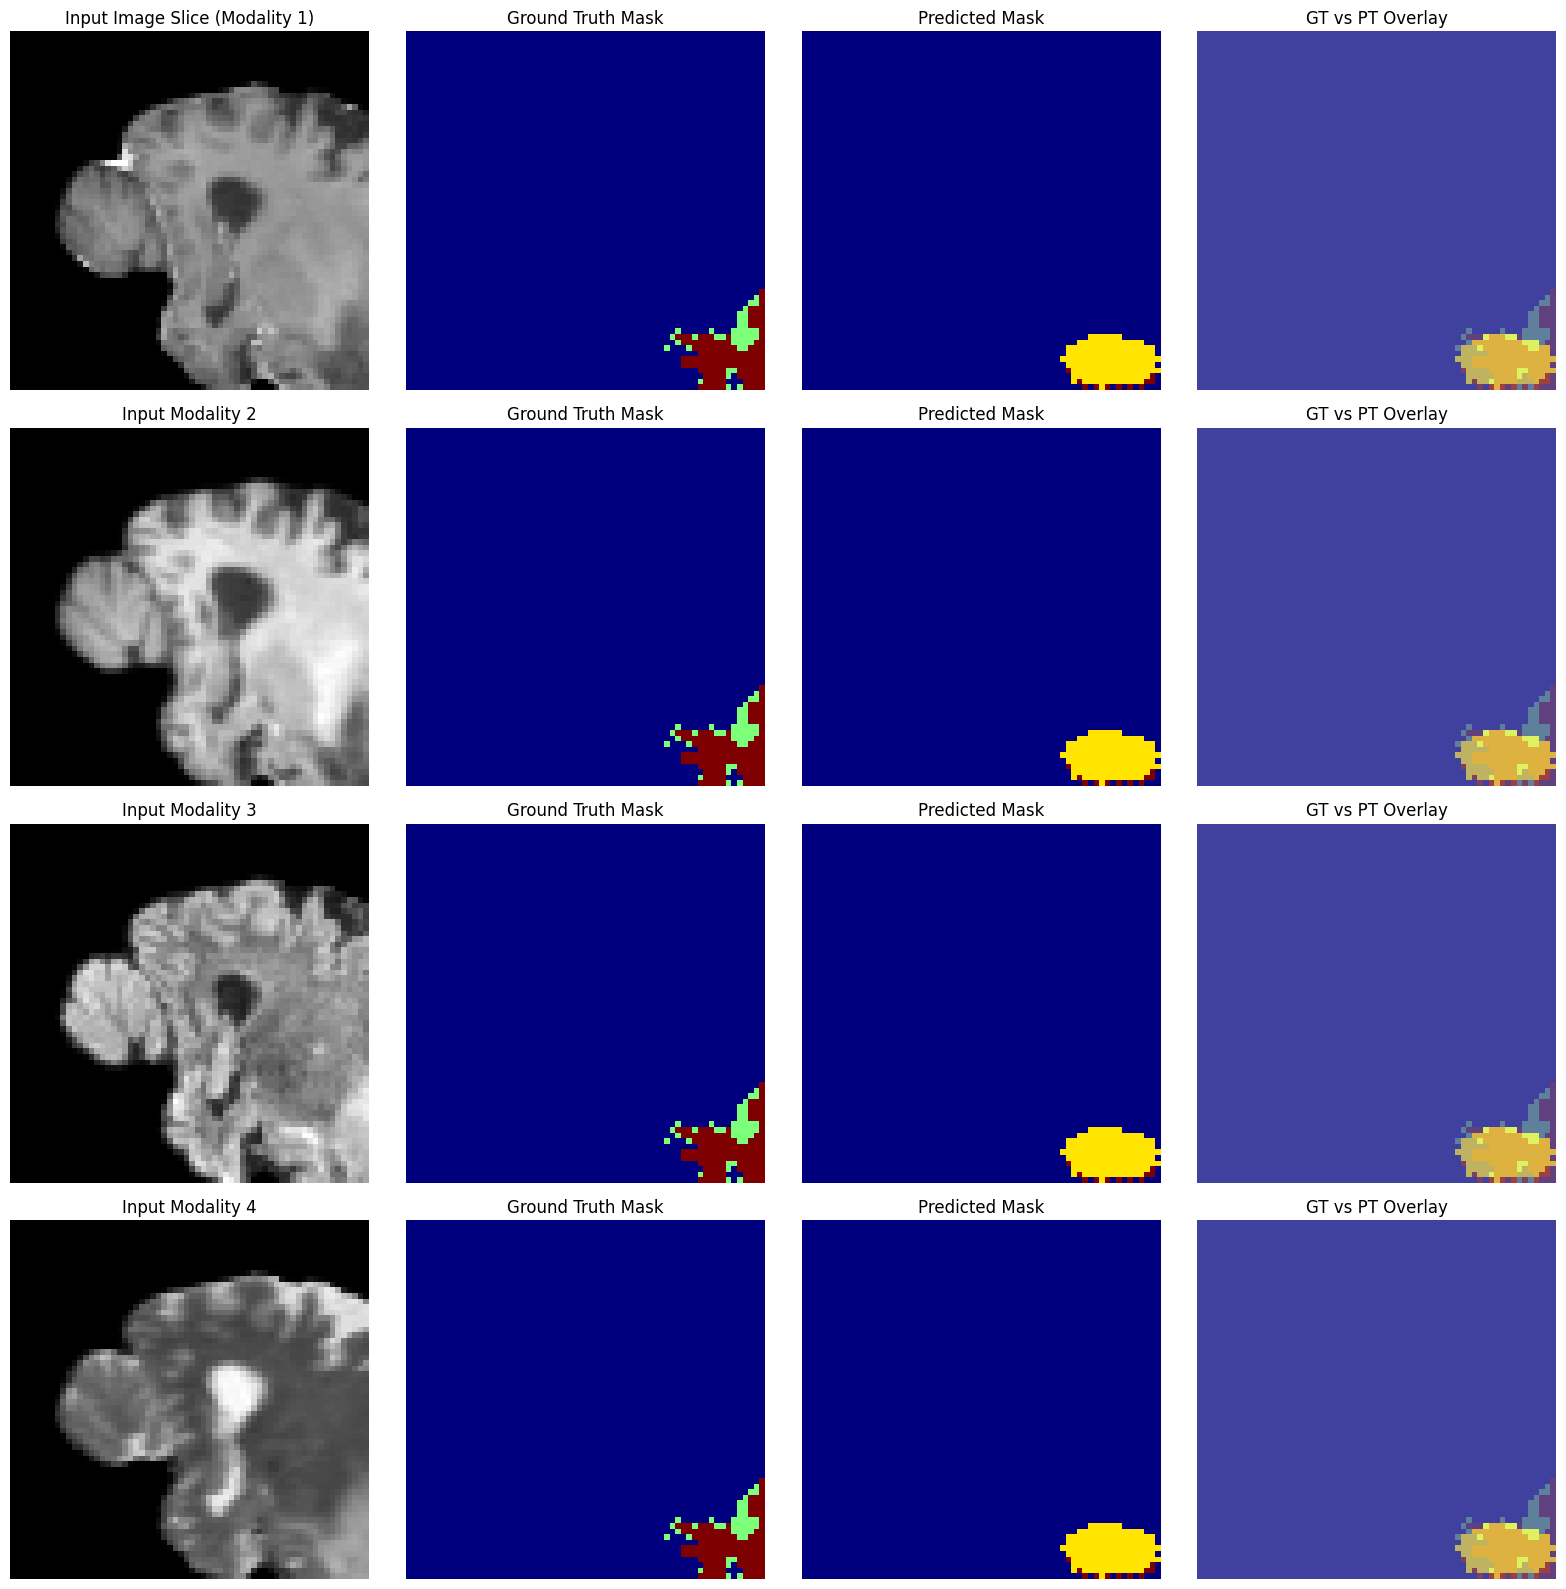

In [ ]:
import torch
from torch.utils.data import DataLoader
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import random
import time

# - BraTSDataset class
# - _3WC_UNet class
# - dice_loss function
# - iou_score function
# - hausdorff_95 function

# Load model and metrics
def load_model_with_features(save_dir, model_filename, config_filename, metrics_filename):
    # Load model state
    checkpoint = torch.load(os.path.join(save_dir, model_filename))
    model = _3WC_UNet()  # Reconstruct the model
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    optimizer = torch.optim.Adam(model.parameters(), lr=checkpoint['hyperparameters']['lr'], weight_decay=checkpoint['hyperparameters']['weight_decay'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Load metrics
    with open(os.path.join(save_dir, metrics_filename), 'r') as f:
        metrics = json.load(f)
    train_losses = metrics['train_losses']
    val_losses = metrics['val_losses']
    dice_scores = [(t, v) for t, v in zip(metrics['dice_scores'][0], metrics['dice_scores'][1])]
    iou_scores = [(t, v) for t, v in zip(metrics['iou_scores'][0], metrics['iou_scores'][1])]
    hd95_scores = [(t, v) for t, v in zip(metrics['hd95_scores'][0], metrics['hd95_scores'][1])]
    boundary_ratios = metrics['boundary_ratios']

    print(f"Model loaded from {os.path.join(save_dir, model_filename)}")
    return model, optimizer, train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios

# Inference, evaluation, and visualization on test data
def test_and_visualize(model, test_data_path, downsample_size=(96, 96, 96), patch_size=(64, 64, 64)):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Load test dataset
    test_dataset = BraTSDataset(test_data_path, downsample_size=downsample_size, patch_size=patch_size)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

    # Initialize metrics
    test_dice = 0
    test_iou = 0
    test_hd95 = 0
    boundary_ratios = []
    patch_count = 0
    total_inference_time = 0

    print("Starting inference and evaluation on test data...")

    with torch.no_grad():
        inference_start_time = time.time()
        for image_patches, mask_patches in test_loader:
            for image_patch, mask_patch in zip(image_patches, mask_patches):
                # Ensure tensors are in the correct shape
                if image_patch.ndim == 4:  # Shape: [C, D, H, W]
                    image_patch = image_patch.unsqueeze(0)  # Add batch dimension: [1, C, D, H, W]
                if mask_patch.ndim == 5:  # Shape: [1, 1, D, H, W]
                    mask_patch = mask_patch.squeeze(0)  # Remove channel dimension if present: [D, H, W]
                elif mask_patch.ndim == 4:  # Shape: [1, D, H, W]
                    mask_patch = mask_patch.squeeze(0)  # Remove batch dimension: [D, H, W]

                image_patch = image_patch.to(device, non_blocking=True).float()
                mask_patch = mask_patch.to(device, non_blocking=True).long().clamp(0, 3)

                # Measure inference time for each patch
                patch_start_time = time.time()
                outputs = model(image_patch)
                patch_end_time = time.time()
                inference_time = patch_end_time - patch_start_time
                total_inference_time += inference_time

                seg = outputs['segmentation']
                boundary_mask = outputs['boundary_masks'][-1]
                boundary_mask = torch.nn.functional.interpolate(boundary_mask, size=seg.shape[2:], mode='trilinear')

                # Calculate metrics
                test_dice += dice_loss(seg, mask_patch.unsqueeze(0)).item()
                test_iou += iou_score(seg, mask_patch.unsqueeze(0))
                test_hd95 += hausdorff_95(seg, mask_patch.unsqueeze(0))
                boundary_ratios.append(boundary_mask.mean().item())
                patch_count += 1

                # Clean up
                del image_patch, mask_patch, outputs, seg, boundary_mask
                torch.cuda.empty_cache()

        inference_end_time = time.time()
        total_time = inference_end_time - inference_start_time

    # Average metrics
    avg_test_dice = test_dice / patch_count if patch_count > 0 else 0
    avg_test_iou = test_iou / patch_count if patch_count > 0 else 0
    avg_test_hd95 = test_hd95 / patch_count if patch_count > 0 else 0
    avg_boundary_ratio = np.mean(boundary_ratios) if boundary_ratios else 0
    avg_inference_time_per_patch = total_inference_time / patch_count if patch_count > 0 else 0

    print(f"Test Metrics: Dice: {avg_test_dice:.4f}, IoU: {avg_test_iou:.4f}, HD95: {avg_test_hd95:.4f}, Boundary Ratio: {avg_boundary_ratio:.4f}")
    print(f"Inference Time: Total: {total_time:.2f} seconds, Per Patch: {avg_inference_time_per_patch:.2f} seconds")

    # Visualization on a random test sample
    plt.figure(figsize=(16, 16))

    with torch.no_grad():
        # Randomly select a sample from the test dataset
        random_idx = random.randint(0, len(test_dataset) - 1)
        image_patches, mask_patches = test_dataset[random_idx]

        # Convert to PyTorch tensors
        image_patch = torch.from_numpy(image_patches[0]).float()
        mask_patch = torch.from_numpy(mask_patches[0]).long()

        if image_patch.ndim == 4:
            image_patch = image_patch.unsqueeze(0)
        if mask_patch.ndim == 5:
            mask_patch = mask_patch.squeeze()
        elif mask_patch.ndim == 4:
            mask_patch = mask_patch.squeeze(0)

        image_patch = image_patch.to(device, non_blocking=True)
        mask_patch = mask_patch.to(device, non_blocking=True).clamp(0, 3)

        outputs = model(image_patch)
        pred_mask = torch.argmax(outputs['segmentation'], dim=1)[0]

        # Move to CPU for visualization
        image_patch = image_patch.cpu()
        mask_patch = mask_patch.cpu()
        pred_mask = pred_mask.cpu()

        # Select a middle slice
        slice_idx = image_patch.shape[2] // 2

        # 4x4 Subplot for Visualization
        plt.subplot(4, 4, 1)
        plt.imshow(image_patch[0, 0, slice_idx].numpy(), cmap='gray')
        plt.title('Input Image Slice (Modality 1)')
        plt.axis('off')

        plt.subplot(4, 4, 2)
        plt.imshow(mask_patch[slice_idx].numpy(), cmap='jet')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(4, 4, 3)
        plt.imshow(pred_mask[slice_idx].numpy(), cmap='jet')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(4, 4, 4)
        plt.imshow(mask_patch[slice_idx].numpy(), cmap='jet', alpha=0.5)
        plt.imshow(pred_mask[slice_idx].numpy(), cmap='jet', alpha=0.5)
        plt.title('GT vs PT Overlay')
        plt.axis('off')

        for i in range(1, 4):
            plt.subplot(4, 4, 4*i + 1)
            plt.imshow(image_patch[0, i, slice_idx].numpy(), cmap='gray')
            plt.title(f'Input Modality {i+1}')
            plt.axis('off')

            plt.subplot(4, 4, 4*i + 2)
            plt.imshow(mask_patch[slice_idx].numpy(), cmap='jet')
            plt.title('Ground Truth Mask')
            plt.axis('off')

            plt.subplot(4, 4, 4*i + 3)
            plt.imshow(pred_mask[slice_idx].numpy(), cmap='jet')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.subplot(4, 4, 4*i + 4)
            plt.imshow(mask_patch[slice_idx].numpy(), cmap='jet', alpha=0.5)
            plt.imshow(pred_mask[slice_idx].numpy(), cmap='jet', alpha=0.5)
            plt.title('GT vs PT Overlay')
            plt.axis('off')

    plt.tight_layout()
    #plt.savefig('test_visualization_results.png')
    plt.show()

if __name__ == "__main__":
    # Example loading and testing
    save_dir = "/content/drive/MyDrive/BraTS_Segmentation_Project/models/model_checkpoints"
    timestamp = "20250530_140740"  # Match the timestamp from your output
    model, optimizer, train_losses, val_losses, dice_scores, iou_scores, hd95_scores, boundary_ratios = load_model_with_features(
        save_dir, f"model_{timestamp}.pth", f"config_{timestamp}.json", f"metrics_{timestamp}.json"
    )
    test_data_path = "/content/drive/MyDrive/BraTS_Segmentation_Project/data/test"
    test_and_visualize(model, test_data_path, downsample_size=(96, 96, 96), patch_size=(64, 64, 64))